In [1]:
import pandas as pd
import text2term as t2t
from text2term import *
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import *
import numpy as np

In [2]:
input_data = pd.read_csv("data/BAO_linking_gold_standard.csv", sep=',')

### Some basic counts

In [3]:
# Number of rows in initial gold standard
len(input_data)

841

In [4]:
# Number of assays in initial gold standard
input_data['assay_id'].nunique()

800

In [5]:
# Some assays don't have a method, these are still included in the initial gold standard, but we don't need them
input_data.loc[input_data['method'].isnull()].head()

,assay_id,assay_type,description,method,bao_preferred_term,bao_id
18,2123220,B,Positive allosteric modulator activity in mous...,NaN,NaN,NaN
27,2163697,B,Binding affinity to FGFR4 (unknown origin) ass...,NaN,NaN,NaN
92,802309,B,Binding affinity at 5-HT2A receptor by radioli...,NaN,NaN,NaN
94,966209,B,Binding affinity to human adenosine A1 recepto...,NaN,NaN,NaN
95,963174,B,Binding affinity to human dopamine D1 receptor...,NaN,NaN,NaN


In [6]:
# Some other rows have a method but don't have a suitable bao identifier
input_data.loc[(~input_data['method'].isnull())&(input_data['bao_id'].isnull())].head()

,assay_id,assay_type,description,method,bao_preferred_term,bao_id
131,1979354,B,Binding affinity to human partial length BRDT ...,BROMOscan assay,NaN,NaN
132,1851040,B,Binding affinity to human partial length TRIM3...,BROMOscan assay,NaN,NaN
134,2262115,B,Binding affinity to human Sirt3 (118 to 399 re...,short DNA nano levers based switchSENSE microf...,NaN,NaN
136,989636,B,Binding affinity to N-terminal domain of human...,FAXS competitive binding assay,NaN,NaN
145,815855,B,Inhibition of GPIbalpha-vWF binding assessed a...,static agglutination assay,NaN,NaN


In [7]:
# Remove rows without methods identified and without bao ids 
gold = input_data.loc[(~input_data['method'].isnull())&(~input_data['bao_id'].isnull())]

In [8]:
# Number of rows
len(gold)

448

In [9]:
# Number of assays
gold['assay_id'].nunique()

407

In [10]:
gold['method'].nunique()

225

In [11]:
gold['bao_id'].nunique()

83

In [12]:
# Count the number of bao annotations per assay
counts = pd.DataFrame(gold.groupby('assay_id').count())
counts

,assay_type,description,method,bao_preferred_term,bao_id
assay_id,,,,,
49482,1,1,1,1,1
52280,1,1,1,1,1
52456,1,1,1,1,1
67359,1,1,1,1,1
159810,1,1,1,1,1
...,...,...,...,...,...
2235893,1,1,1,1,1
2237671,1,1,1,1,1
2248318,1,1,1,1,1


In [13]:
# How many assays have 1, 2, 3 bao mappings per assay?
counts['assay_type'].value_counts()

assay_type
1    377
2     19
3     11
Name: count, dtype: int64

In [14]:
gold_single_mappings = gold.loc[gold['assay_id'].isin(counts.loc[counts['assay_type']==1].index)]

In [15]:
gold_single_mappings['assay_id'].nunique()

377

In [16]:
gold_multiple_mappings = gold.loc[gold['assay_id'].isin(counts.loc[counts['assay_type']!=1].index)]

In [17]:
gold_multiple_mappings['assay_id'].nunique()

30

In [18]:
len(gold_multiple_mappings)

71

In [19]:
# Fraction of assays with only single mappings
gold_single_mappings['assay_id'].nunique() / gold['assay_id'].nunique()

0.9262899262899262

In [20]:
# Fraction of assays with multiple mappings
gold_multiple_mappings['assay_id'].nunique() / gold['assay_id'].nunique()

0.07371007371007371

### Load the BAO ontology owl file

In [21]:
# Caches the ontology in memory
cache_ontology("data/bao_complete_2.8.12.owl", ontology_acronym="bao", base_iris=())

2025-06-06 11:42:54 INFO [text2term.term_collector]: Loading ontology data/bao_complete_2.8.12.owl...
2025-06-06 11:43:16 INFO [text2term.term_collector]: ...done (ontology loading time: 22.08s)
2025-06-06 11:43:16 INFO [text2term.term_collector]: Collecting ontology term details...
2025-06-06 11:43:16 INFO [text2term.term_collector]: ...done: collected 802 ontology terms (collection time: 0.11s)
2025-06-06 11:43:16 INFO [text2term.t2t]: Filtered ontology terms to those of type: OntologyTermType.ANY
2025-06-06 11:43:16 INFO [text2term.t2t]: Caching ontology data/bao_complete_2.8.12.owl to: cache/bao


### First evaluate on the single matches

In [22]:
#executes text2term in the dataset with BAO annotates assays 
single_mappings_ann_data = t2t.map_terms(source_terms = gold_single_mappings['method'],
                     target_ontology = 'bao',
                     mapper = Mapper.TFIDF,
                     #base_iris = 'http://www.bioassayontology.org/bao#',
                     min_score=0.02,
                     max_mappings=50,
                     term_type=OntologyTermType.CLASS,
                     use_cache=True)

2025-06-06 11:43:16 INFO [text2term.t2t]: Loading cached ontology from: cache/bao/bao-term-details.pickle
2025-06-06 11:43:16 INFO [text2term.t2t]: Filtered ontology terms to those of type: OntologyTermType.CLASS
2025-06-06 11:43:16 INFO [text2term.t2t]: Mapping 377 source terms to bao
2025-06-06 11:43:25 INFO [text2term.t2t]: ...done (mapping time: 8.28s seconds)


In [23]:
single_mappings_ann_data.head()

,Source Term ID,Source Term,Mapped Term Label,Mapped Term CURIE,Mapped Term IRI,Mapping Score,Tags
0,http://ccb.hms.harvard.edu/t2t/RttoQSun6ud,FRET-based assay,cell based format,BAO:0000219,http://www.bioassayontology.org/bao#BAO_0000219,0.394,None
1,http://ccb.hms.harvard.edu/t2t/RttoQSun6ud,FRET-based assay,dna-coated bead based method,BAO:0002022,http://www.bioassayontology.org/bao#BAO_0002022,0.322,None
2,http://ccb.hms.harvard.edu/t2t/RttoQSun6ud,FRET-based assay,Kinase NanoBRET Assay,BAO:0010069,http://www.bioassayontology.org/bao#BAO_0010069,0.315,None
3,http://ccb.hms.harvard.edu/t2t/RttoQSun6ud,FRET-based assay,Bead-based immunoassay for protein state,BAO:0010050,http://www.bioassayontology.org/bao#BAO_0010050,0.241,None
4,http://ccb.hms.harvard.edu/t2t/RttoQSun6ud,FRET-based assay,image-based readout,BAO:0000184,http://www.bioassayontology.org/bao#BAO_0000184,0.234,None


In [24]:
single_mappings_ann_data['bao_id_mapped'] = single_mappings_ann_data['Mapped Term CURIE'].apply(lambda x: x.replace(':', '_'))

In [25]:
merged_df = gold_single_mappings.merge(single_mappings_ann_data, left_on='method', right_on='Source Term', how='outer')

In [26]:
merged_df['assay_id'].nunique()

377

In [27]:
def decide_correct(row):
    if row['bao_id'] == row['bao_id_mapped']:
        return 1
    else:
        return 0

In [28]:
merged_df['suggested_mapping_correct'] = merged_df.apply(decide_correct, axis=1)

In [29]:
merged_df.head()

,assay_id,assay_type,description,method,bao_preferred_term,bao_id,Source Term ID,Source Term,Mapped Term Label,Mapped Term CURIE,Mapped Term IRI,Mapping Score,Tags,bao_id_mapped,suggested_mapping_correct
0,1912425,B,Binding affinity to wild-type TTR (unknown ori...,2D TROSY [1H-15N] spectroscopy,nuclear magnetic resonance,BAO_0000160,http://ccb.hms.harvard.edu/t2t/Rwt8c5848kx,2D TROSY [1H-15N] spectroscopy,computational electron microscopy structure so...,BAO:0002220,http://www.bioassayontology.org/bao#BAO_0002220,0.290,None,BAO_0002220,0
1,1912425,B,Binding affinity to wild-type TTR (unknown ori...,2D TROSY [1H-15N] spectroscopy,nuclear magnetic resonance,BAO_0000160,http://ccb.hms.harvard.edu/t2t/Rwt8c5848kx,2D TROSY [1H-15N] spectroscopy,Liquid Chromatography/Mass Spectroscopy (LC/MS...,BAO:0010071,http://www.bioassayontology.org/bao#BAO_0010071,0.284,None,BAO_0010071,0
2,1912425,B,Binding affinity to wild-type TTR (unknown ori...,2D TROSY [1H-15N] spectroscopy,nuclear magnetic resonance,BAO_0000160,http://ccb.hms.harvard.edu/t2t/Rwt8c5848kx,2D TROSY [1H-15N] spectroscopy,mass spectrometry,BAO:0000055,http://www.bioassayontology.org/bao#BAO_0000055,0.270,None,BAO_0000055,0
3,1912425,B,Binding affinity to wild-type TTR (unknown ori...,2D TROSY [1H-15N] spectroscopy,nuclear magnetic resonance,BAO_0000160,http://ccb.hms.harvard.edu/t2t/Rwt8c5848kx,2D TROSY [1H-15N] spectroscopy,2D structure prediction,BAO:0002213,http://www.bioassayontology.org/bao#BAO_0002213,0.147,None,BAO_0002213,0
4,1912425,B,Binding affinity to wild-type TTR (unknown ori...,2D TROSY [1H-15N] spectroscopy,nuclear magnetic resonance,BAO_0000160,http://ccb.hms.harvard.edu/t2t/Rwt8c5848kx,2D TROSY [1H-15N] spectroscopy,bioassay specification,BAO:0000026,http://www.bioassayontology.org/bao#BAO_0000026,0.117,None,BAO_0000026,0


In [30]:
merged_df.drop(columns=['Source Term ID'], inplace=True)

In [31]:
merged_df = merged_df.drop_duplicates()

In [32]:
merged_df.tail()

,assay_id,assay_type,description,method,bao_preferred_term,bao_id,Source Term,Mapped Term Label,Mapped Term CURIE,Mapped Term IRI,Mapping Score,Tags,bao_id_mapped,suggested_mapping_correct
52433,649008,F,Agonist activity at muscarinic M4 receptor in ...,whole-cell electrophysiology,electrophysiological method,BAO_0000424,whole-cell electrophysiology,cell viability ATP quantitation assay,BAO:0010001,http://www.bioassayontology.org/bao#BAO_0010001,0.117,None,BAO_0010001,0
52434,649008,F,Agonist activity at muscarinic M4 receptor in ...,whole-cell electrophysiology,electrophysiological method,BAO_0000424,whole-cell electrophysiology,autophagosome,GO:0005776,http://purl.obolibrary.org/obo/GO_0005776,0.117,None,GO_0005776,0
52435,649008,F,Agonist activity at muscarinic M4 receptor in ...,whole-cell electrophysiology,electrophysiological method,BAO_0000424,whole-cell electrophysiology,Fluorescence imaging cell count assay,BAO:0010054,http://www.bioassayontology.org/bao#BAO_0010054,0.115,None,BAO_0010054,0
52436,649008,F,Agonist activity at muscarinic M4 receptor in ...,whole-cell electrophysiology,electrophysiological method,BAO_0000424,whole-cell electrophysiology,mass spectrometry,BAO:0000055,http://www.bioassayontology.org/bao#BAO_0000055,0.114,None,BAO_0000055,0
52437,649008,F,Agonist activity at muscarinic M4 receptor in ...,whole-cell electrophysiology,electrophysiological method,BAO_0000424,whole-cell electrophysiology,induced pluripotent stem cell,BAO:0000119,http://www.bioassayontology.org/bao#BAO_0000119,0.113,None,BAO_0000119,0


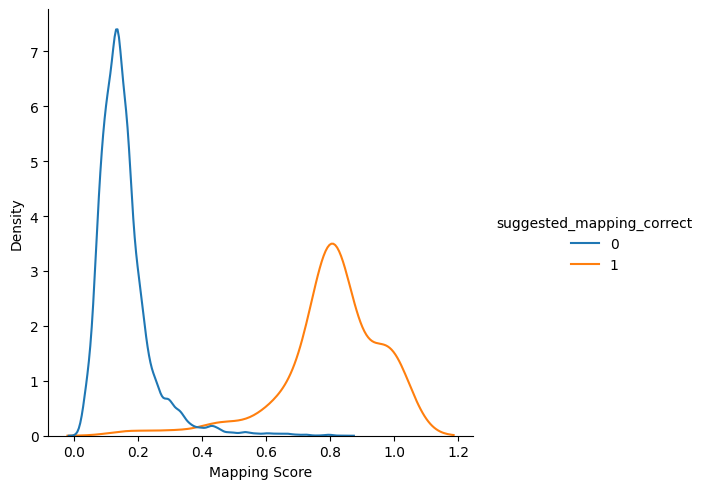

In [33]:
sns.displot(merged_df, x="Mapping Score", kind='kde', hue='suggested_mapping_correct', common_norm=False)
plt.savefig('./plots/mapping_scores_density_single_mappings.png', dpi=150)

### Submit assays with multiple mappings to text2term - need separate evaluation

In [34]:
gold_multiple_mappings.head()

,assay_id,assay_type,description,method,bao_preferred_term,bao_id
24,1708876,B,Binding affinity to AURKB in human NCI-H358 ce...,mass spectrometry based pull down assay,affinity selection,BAO_0002501
25,1708876,B,Binding affinity to AURKB in human NCI-H358 ce...,mass spectrometry based pull down assay,mass spectrometry,BAO_0000055
31,1708761,B,Binding affinity to HAX1 in human NCI-H358 cel...,mass spectrometry based pull down assay,affinity selection,BAO_0002501
32,1708761,B,Binding affinity to HAX1 in human NCI-H358 cel...,mass spectrometry based pull down assay,mass spectrometry,BAO_0000055
46,1708895,B,Binding affinity to MAP2K2 in human NCI-H358 c...,mass spectrometry based pull down assay,affinity selection,BAO_0002501


In [35]:
method_list = list(gold_multiple_mappings['method'].drop_duplicates())
method_list

['mass spectrometry based pull down assay',
 'HSQC NMR-based titration method',
 'fluorescence titration analysis',
 'Microbeta TriLux based luminescence analysis',
 'filter binding radioactive ATP transferase assay',
 'annexin V-PE and 7-AAD staining based flow cytometry analysis',
 'PI staining based flow cytometric analysis',
 'PI staining based flow cytometry analysis',
 'annexin-V/propidium iodide double staining based flow cytometry',
 'propidium iodide staining flow cytometry',
 'Annexin V-FITC/propidium iodide based flow cytometry',
 'Hoechst 33258 staining by fluorescence microscopic analysis',
 'annexin V/propidium iodide staining-based flow cytometric analysis',
 'annexin V/PI staining-based FACS analysis',
 'annexin V-FITC/propidium iodide staining based flow cytometry analysis',
 'annexin V-FITC and PI staining based flow cytometry',
 'Annexin V-FITC/propidium iodide staining based flow cytometry',
 'Annexin V-FITC/propidium iodide staining-based flow cytometric analysis',

In [36]:
#executes text2term in the dataset with BAO annotates assays 
multiple_mappings_ann_data = t2t.map_terms(source_terms = method_list,
                     target_ontology = 'bao',
                     mapper = Mapper.TFIDF,
                     #base_iris = 'http://www.bioassayontology.org/bao#',
                     min_score=0.02,
                     max_mappings=50,
                     term_type=OntologyTermType.CLASS,
                     use_cache=True)

2025-06-06 11:43:26 INFO [text2term.t2t]: Loading cached ontology from: cache/bao/bao-term-details.pickle
2025-06-06 11:43:26 INFO [text2term.t2t]: Filtered ontology terms to those of type: OntologyTermType.CLASS
2025-06-06 11:43:26 INFO [text2term.t2t]: Mapping 25 source terms to bao
2025-06-06 11:43:26 INFO [text2term.t2t]: ...done (mapping time: 0.05s seconds)


In [37]:
multiple_mappings_ann_data['bao_id_mapped'] = multiple_mappings_ann_data['Mapped Term CURIE'].apply(lambda x: x.replace(':', '_'))

In [38]:
multiple_merged_df = gold_multiple_mappings.merge(multiple_mappings_ann_data, left_on='method', right_on='Source Term', how='outer')

In [39]:
multiple_merged_df.sort_values(by=['assay_id', 'method'], inplace=True)

In [40]:
#multiple_merged_df.to_csv("./data/multiple_mappings_to_inspect.csv", index=False)

In [41]:
# Keep a copy of the text2term annotations for multiple mappings while keeping the assay id only
# This will help set up set-based evaluation rather than row-based (grouped by assay id)
multiples_ann_assay_ids = multiple_merged_df.drop(labels=['assay_type', 'description', 'method', 'bao_preferred_term', 'bao_id', 'Source Term ID'], axis='columns').drop_duplicates()
multiples_ann_assay_ids.head()

,assay_id,Source Term,Mapped Term Label,Mapped Term CURIE,Mapped Term IRI,Mapping Score,Tags,bao_id_mapped
3097,631920,propidium iodide staining-based FACS analysis,computational structure analysis,BAO:0002212,http://www.bioassayontology.org/bao#BAO_0002212,0.281,None,BAO_0002212
3098,631920,propidium iodide staining-based FACS analysis,Gram staining,BAO:0002844,http://www.bioassayontology.org/bao#BAO_0002844,0.263,None,BAO_0002844
3099,631920,propidium iodide staining-based FACS analysis,comparative molecular field analysis,BAO:0002313,http://www.bioassayontology.org/bao#BAO_0002313,0.213,None,BAO_0002313
3100,631920,propidium iodide staining-based FACS analysis,self organizing molecular field analysis,BAO:0002315,http://www.bioassayontology.org/bao#BAO_0002315,0.210,None,BAO_0002315
3101,631920,propidium iodide staining-based FACS analysis,quantitative structure activity relationship a...,BAO:0002305,http://www.bioassayontology.org/bao#BAO_0002305,0.196,None,BAO_0002305


In [42]:
gold_multiple_mappings.head()

,assay_id,assay_type,description,method,bao_preferred_term,bao_id
24,1708876,B,Binding affinity to AURKB in human NCI-H358 ce...,mass spectrometry based pull down assay,affinity selection,BAO_0002501
25,1708876,B,Binding affinity to AURKB in human NCI-H358 ce...,mass spectrometry based pull down assay,mass spectrometry,BAO_0000055
31,1708761,B,Binding affinity to HAX1 in human NCI-H358 cel...,mass spectrometry based pull down assay,affinity selection,BAO_0002501
32,1708761,B,Binding affinity to HAX1 in human NCI-H358 cel...,mass spectrometry based pull down assay,mass spectrometry,BAO_0000055
46,1708895,B,Binding affinity to MAP2K2 in human NCI-H358 c...,mass spectrometry based pull down assay,affinity selection,BAO_0002501


In [43]:
gold_multiples_sets = (gold_multiple_mappings
 .groupby('assay_id')
 .agg({'description': 'first', 'method': 'first', 'bao_preferred_term': list, 'bao_id': list})
 .reset_index()
)
gold_multiples_sets

,assay_id,description,method,bao_preferred_term,bao_id
0,631920,Cell cycle arrest in human A2780 cells assesse...,propidium iodide staining-based FACS analysis,"[propidium iodide DNA staining, flow cytometry]","[BAO_0002476, BAO_0000005]"
1,746641,Induction of apoptosis in human Raji cells ass...,annexin V-FITC/propidium iodide staining by FACS,"[propidium iodide DNA staining, flow cytometry...","[BAO_0002476, BAO_0000005, BAO_0010265]"
2,796334,Cell cycle arrest in human SK-BR-3 cells asses...,propidium iodide staining by FACS analysis,"[propidium iodide DNA staining, flow cytometry]","[BAO_0002476, BAO_0000005]"
3,964025,Cell cycle arrest in human Bel7402 cells asses...,propidium iodide staining-based FACS analysis,"[propidium iodide DNA staining, flow cytometry]","[BAO_0002476, BAO_0000005]"
4,966269,Cell cycle arrest in human MGC803 cells assess...,propidium iodide staining-based flow cytometry,"[propidium iodide DNA staining, flow cytometry]","[BAO_0002476, BAO_0000005]"
5,1339546,Induction of apoptosis in human A549 cells ass...,annexin V/PI staining-based FACS analysis,"[propidium iodide DNA staining, flow cytometry...","[BAO_0002476, BAO_0000005, BAO_0010265]"
6,1472216,Induction of apoptosis in human HepG2 cells as...,annexin V/propidium iodide staining-based flow...,"[propidium iodide DNA staining, flow cytometry...","[BAO_0002476, BAO_0000005, BAO_0010265]"
7,1475233,Binding affinity to RPA70N protein (unknown or...,HSQC NMR-based titration method,"[nuclear magnetic resonance, titration method]","[BAO_0000160, BAO_0002413]"
8,1516953,Induction of apoptosis in human MGC803 cells a...,Hoechst 33258 staining by fluorescence microsc...,"[Hoechst, fluorescence microscopy]","[BAO_0000116, BAO_0000450]"
9,1651980,Poison activity at recombinant human topoisome...,ethidium bromide staining based agarose gel el...,"[ethidium bromide DNA staining, agarose gel]","[BAO_0002474, BAO_0010020]"


In [44]:
gold_multiples_sets.loc[gold_multiples_sets['assay_id']==2210648,'bao_id'].values[0]

['BAO_0000046', 'BAO_0001217', 'BAO_0002418']

In [45]:
def decide_correct_multiples(row):
    assay_id = row['assay_id']
    bao_ids_set = gold_multiples_sets.loc[gold_multiples_sets['assay_id']==assay_id,'bao_id'].values[0]
    if row['bao_id_mapped'] in bao_ids_set:
        return 1
    else:
        return 0

In [46]:
multiples_ann_assay_ids['suggested_mapping_correct'] = multiples_ann_assay_ids.apply(decide_correct_multiples, axis=1)

In [47]:
multiples_ann_assay_ids['suggested_mapping_correct'].value_counts()

suggested_mapping_correct
0    1367
1      18
Name: count, dtype: int64

In [48]:
multiples_ann_assay_ids.loc[multiples_ann_assay_ids['assay_id']==2210648]

,assay_id,Source Term,Mapped Term Label,Mapped Term CURIE,Mapped Term IRI,Mapping Score,Tags,bao_id_mapped,suggested_mapping_correct
2283,2210648,jump-dilution based Amplex red and horseradish...,Amplex red reagent,BAO:0001217,http://www.bioassayontology.org/bao#BAO_0001217,0.342,None,BAO_0001217,1
2284,2210648,jump-dilution based Amplex red and horseradish...,Fluorescence imaging protein state assay,BAO:0010059,http://www.bioassayontology.org/bao#BAO_0010059,0.289,None,BAO_0010059,0
2285,2210648,jump-dilution based Amplex red and horseradish...,Fluorescence imaging cell growth inhibition assay,BAO:0010056,http://www.bioassayontology.org/bao#BAO_0010056,0.285,None,BAO_0010056,0
2286,2210648,jump-dilution based Amplex red and horseradish...,Fluorescence imaging cell count assay,BAO:0010054,http://www.bioassayontology.org/bao#BAO_0010054,0.281,None,BAO_0010054,0
2287,2210648,jump-dilution based Amplex red and horseradish...,monoamine oxidase inhibition assay,BAO:0010158,http://www.bioassayontology.org/bao#BAO_0010158,0.276,None,BAO_0010158,0
2288,2210648,jump-dilution based Amplex red and horseradish...,Fluorescence imaging apoptosis assay,BAO:0010053,http://www.bioassayontology.org/bao#BAO_0010053,0.273,None,BAO_0010053,0
2289,2210648,jump-dilution based Amplex red and horseradish...,Fluorescence imaging cell cycle state assay,BAO:0010055,http://www.bioassayontology.org/bao#BAO_0010055,0.271,None,BAO_0010055,0
2290,2210648,jump-dilution based Amplex red and horseradish...,Fluorescence imaging multiplex cytological pro...,BAO:0010058,http://www.bioassayontology.org/bao#BAO_0010058,0.266,None,BAO_0010058,0
2291,2210648,jump-dilution based Amplex red and horseradish...,Fluorescence imaging morphology assay,BAO:0010057,http://www.bioassayontology.org/bao#BAO_0010057,0.260,None,BAO_0010057,0
2292,2210648,jump-dilution based Amplex red and horseradish...,Fluorescein,BAO:0001216,http://www.bioassayontology.org/bao#BAO_0001216,0.251,None,BAO_0001216,0


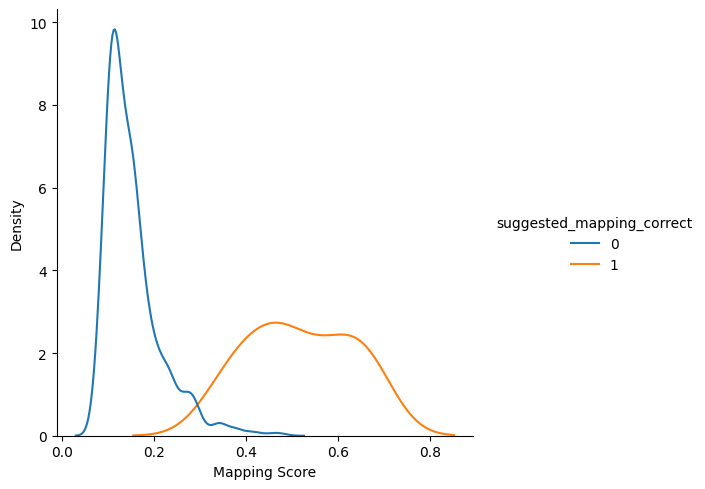

In [49]:
sns.displot(multiples_ann_assay_ids, x="Mapping Score", kind='kde', hue='suggested_mapping_correct', common_norm=False)
plt.savefig('./plots/mapping_scores_density_multiple_mappings.png', dpi=150)

### How much recall do we get if we only take the first mapping (highest score)  - for single mappings only

In [50]:
d = dict.fromkeys(merged_df.columns.difference(['Mapping Score']), 'first')
d['Mapping Score'] = 'max'

In [51]:
maximum_mappings_only_singles = merged_df.groupby('assay_id').agg(d)
maximum_mappings_only_singles

,Mapped Term CURIE,Mapped Term IRI,Mapped Term Label,Source Term,Tags,assay_id,assay_type,bao_id,bao_id_mapped,bao_preferred_term,description,method,suggested_mapping_correct,Mapping Score
assay_id,,,,,,,,,,,,,,
49482,BAO:0000957,http://www.bioassayontology.org/bao#BAO_0000957,lithium chloride,ethidium bromide displacement assay,None,49482,B,BAO_0002474,BAO_0000957,ethidium bromide DNA staining,The ability to reversibly bind to DNA using et...,ethidium bromide displacement assay,0,0.238
52280,BAO:0000957,http://www.bioassayontology.org/bao#BAO_0000957,lithium chloride,ethidium bromide displacement,None,52280,B,BAO_0002474,BAO_0000957,ethidium bromide DNA staining,Binding constant for DNA by ethidium bromide d...,ethidium bromide displacement,0,0.241
52456,BAO:0000957,http://www.bioassayontology.org/bao#BAO_0000957,lithium chloride,ethidium bromide dye displacement assay,None,52456,B,BAO_0002474,BAO_0000957,ethidium bromide DNA staining,Ability to interact with DNA was assessed by a...,ethidium bromide dye displacement assay,0,0.224
67359,BAO:0002995,http://www.bioassayontology.org/bao#BAO_0002995,transcriptional profiling assay,transcriptional activation assay,None,67359,B,BAO_0010044,BAO_0002995,targeted transcriptional assay,Functional ERalpha receptor activity in transc...,transcriptional activation assay,0,0.642
159810,BAO:0010134,http://www.bioassayontology.org/bao#BAO_0010134,placental transfer assay,ethidium displacement assay,None,159810,B,BAO_0002474,BAO_0010134,ethidium bromide DNA staining,Apparent binding constant was determined by et...,ethidium displacement assay,0,0.244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235893,BAO:0002212,http://www.bioassayontology.org/bao#BAO_0002212,computational structure analysis,LC-MS analysis,None,2235893,B,BAO_0000055,BAO_0002212,mass spectrometry,Covalent binding affinity to N-terminal His-Sm...,LC-MS analysis,0,0.347
2237671,BAO:0000248,http://www.bioassayontology.org/bao#BAO_0000248,assay kit,SRB assay,None,2237671,F,BAO_0002460,BAO_0000248,sulforhodamine B staining,Cytotoxicity against human LXFL 529 cells asse...,SRB assay,0,0.206
2248318,BAO:0010170,http://www.bioassayontology.org/bao#BAO_0010170,CYP time dependent inhibition IC50 shift assay,thermal shift assay,None,2248318,B,BAO_0040024,BAO_0010170,thermal shift assessment method,Binding affinity to His6-fused BRD3 BD2 (unkno...,thermal shift assay,0,0.366


In [52]:
maximum_mappings_only_singles['suggested_mapping_correct'].value_counts()

suggested_mapping_correct
0    300
1     77
Name: count, dtype: int64

In [53]:
77/377

0.20424403183023873

In [54]:
# precision
77 / 377

0.20424403183023873

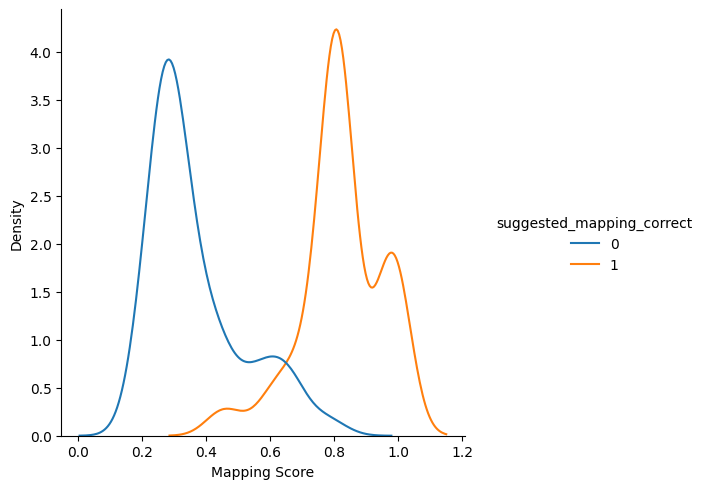

In [55]:
sns.displot(maximum_mappings_only_singles, x="Mapping Score", kind='kde', hue='suggested_mapping_correct', common_norm=False)

In [56]:
# If we take cut-off 0.6, what is recall and precision?
maximum_mappings_only_singles_cutoff = maximum_mappings_only_singles.loc[maximum_mappings_only_singles['Mapping Score']>0.6]

In [57]:
len(maximum_mappings_only_singles_cutoff)

111

In [58]:
maximum_mappings_only_singles_cutoff['suggested_mapping_correct'].value_counts()

suggested_mapping_correct
1    72
0    39
Name: count, dtype: int64

In [59]:
# Recall
72 / 377 

0.1909814323607427

In [60]:
# Precision
72 / (72+39)

0.6486486486486487

### How much recall do we get if we only take all mappings with score > 0.6  - for single mappings only

In [61]:
merged_df['assay_id'].nunique()

377

In [62]:
min_score = merged_df.loc[merged_df['Mapping Score'] > 0.6]

In [63]:
min_score['suggested_mapping_correct'].value_counts()

suggested_mapping_correct
0    86
1    73
Name: count, dtype: int64

In [64]:
# Recall - retrieving 19%
73 / 377

0.19363395225464192

In [65]:
# Precision - 46% of suggestions are correct
73 / (73+86)

0.4591194968553459

### How much recall do we get if we only take all mappings with score > 0.7  - for single mappings only

In [66]:
min_score2 = merged_df.loc[merged_df['Mapping Score'] > 0.7]

In [67]:
min_score2['suggested_mapping_correct'].value_counts()

suggested_mapping_correct
1    68
0    23
Name: count, dtype: int64

In [68]:
# Recall - retrieving 18%
68 / 377

0.18037135278514588

In [69]:
# Precision - 74% of suggestions are correct
68 / (68+23)

0.7472527472527473

In [70]:
min_score2.groupby(['suggested_mapping_correct'])['assay_id'].nunique()

suggested_mapping_correct
0    17
1    68
Name: assay_id, dtype: int64

### How much recall do we get if we only take all mappings with score > 0.8  - for single mappings only

In [71]:
min_score2 = merged_df.loc[merged_df['Mapping Score'] > 0.8]

In [72]:
min_score2['suggested_mapping_correct'].value_counts()

suggested_mapping_correct
1    61
0     1
Name: count, dtype: int64

In [73]:
# Recall - retrieving 16%
61 / 377

0.16180371352785147

In [74]:
# Precision - 98% of suggestions are correct
61 / (61+1)

0.9838709677419355

### Precision-recall curves

I'm not using the scikit-learn precision_recall_curve (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html) because that's tailored to binary classification, whereas we have an information retrieval task. I found using the precision_recall_curve function calculates recall wrongly because it doesn't take into account the false negatives from the gold standard. That's why I implemented the functions below (Thanks to Santosh Tirunagari).

Precision	TP / (TP + FP)	How many retrieved links were correct

Recall	TP / (TP + FN)	How many gold links were found

F1 Score	2 × (Precision × Recall) / (Precision + Recall)

In [75]:
def calculate_precision_at_threshold(text2term_suggestions_df, threshold):
    # How many retrieved links were correct
    above_threshold_df = text2term_suggestions_df.loc[text2term_suggestions_df['Mapping Score'] > threshold]
    tp = len(above_threshold_df.loc[above_threshold_df['suggested_mapping_correct']==1])
    fp = len(above_threshold_df.loc[above_threshold_df['suggested_mapping_correct']==0])
    precision = tp / (tp + fp)
    return precision

In [76]:
calculate_precision_at_threshold(merged_df, threshold=0.6)

0.4591194968553459

In [77]:
def calculate_recall_at_threshold(text2term_suggestions_df, gold_df, threshold):
    # How many gold links were found
    above_threshold_df = text2term_suggestions_df.loc[text2term_suggestions_df['Mapping Score'] > threshold]
    tp = len(above_threshold_df.loc[above_threshold_df['suggested_mapping_correct']==1])
    # recall = tp / (tp + fn)
    # In this case (tp + fn) is equal to the length of the gold standard (all cases that should have been found)
    recall = tp / len(gold_df)
    return recall

In [78]:
calculate_recall_at_threshold(merged_df, gold_single_mappings, threshold=0.6)

0.19363395225464192

In [79]:
# Get 500 evenly spaced points between 0.1 and 0.99 for the curve generation
points = np.linspace(0.1, 0.99, 500)

In [80]:
precision_points = [calculate_precision_at_threshold(merged_df, threshold=x) for x in points]
recall_points = [calculate_recall_at_threshold(merged_df, gold_single_mappings, threshold=x) for x in points]
pr_auc = auc(recall_points, precision_points)

In [81]:
threshold_points = np.arange(0.2, 1.0, 0.1)
plt.figure(figsize=(9, 7.5))

def plot_pr_curve(precision, recall, thresholds, pr_auc, label, color, threshold_points):
    plt.plot(recall, precision, color=color, lw=2, label=f'{label} (AUC = {pr_auc:.2f})')

    for threshold in threshold_points:
        # Find the closest point in the thresholds array
        idx = np.argmin(np.abs(thresholds - threshold))
        x, y = recall[idx], precision[idx]

        plt.plot(x, y, 'x', markersize=6, color=color)
        plt.annotate(
            f'{threshold:.2f}',
            (x, y),
            textcoords="offset points",
            xytext=(5, -5),  # Position the label slightly away from the point
            ha='left',
            color='black',
            fontsize=9,
            bbox=dict(boxstyle='round,pad=0.2', edgecolor=color, facecolor='white', alpha=0.8)
        )

<Figure size 900x750 with 0 Axes>

/tmp/ipykernel_3858497/1494029829.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels([f'{x:.2f}'.format(x) for x in current_values])


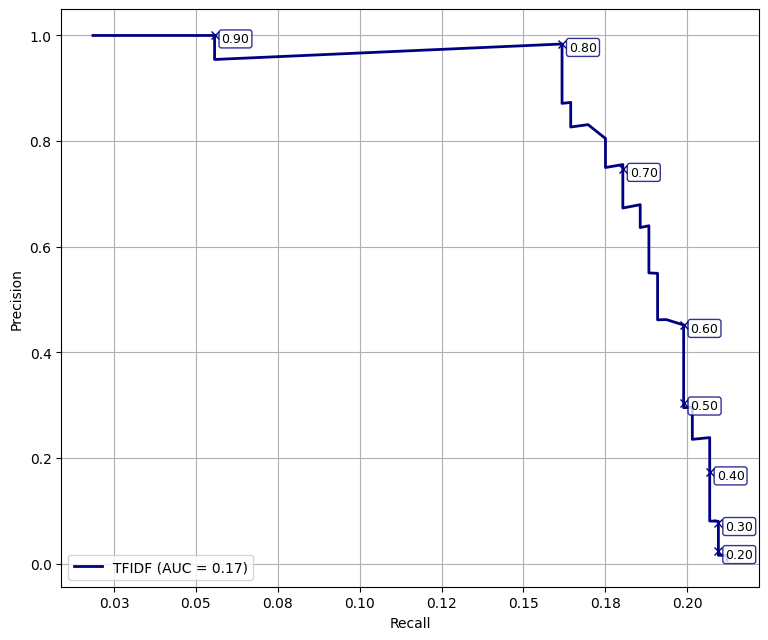

In [82]:
plt.figure(figsize=(9, 7.5))

plot_pr_curve(precision_points, recall_points, points, pr_auc, color='navy', label='TFIDF', threshold_points=threshold_points)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")
plt.grid(True)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels([f'{x:.2f}'.format(x) for x in current_values])
plt.savefig('./plots/PR_curve_single_mappings.png', dpi=150)

### Combine single and multiple mappings for combined evaluation

In [83]:
gold.head()

,assay_id,assay_type,description,method,bao_preferred_term,bao_id
0,1870082,B,Agonist activity at GAL4 DNA binding domain fu...,FRET-based assay,fluorescence resonance energy transfer,BAO_0000001
1,1991217,B,Agonist activity at human FXR expressed in hum...,luciferase reporter gene assay,luciferase reporter gene assay,BAO_0002661
2,2168604,B,Antagonist activity at ERbeta (unknown origin)...,LanthaScreen TR-FRET assay,time resolved fluorescence resonance energy tr...,BAO_0000004
3,643730,B,Antagonist activity at mouse cloned Smo recept...,luciferase reporter gene assay,luciferase reporter gene assay,BAO_0002661
4,835167,B,Inhibition of FGFR2 by TR-FRET analysis,TR-FRET analysis,time resolved fluorescence resonance energy tr...,BAO_0000004


In [84]:
len(gold)

448

In [85]:
singles_annotated = merged_df.drop(labels=['assay_type', 'bao_id','description', 'method', 'bao_preferred_term'], axis='columns')

In [86]:
singles_annotated.columns

Index(['assay_id', 'Source Term', 'Mapped Term Label', 'Mapped Term CURIE',
       'Mapped Term IRI', 'Mapping Score', 'Tags', 'bao_id_mapped',
       'suggested_mapping_correct'],
      dtype='object')

In [87]:
multiples_ann_assay_ids.columns

Index(['assay_id', 'Source Term', 'Mapped Term Label', 'Mapped Term CURIE',
       'Mapped Term IRI', 'Mapping Score', 'Tags', 'bao_id_mapped',
       'suggested_mapping_correct'],
      dtype='object')

In [88]:
all_annotations = pd.concat([singles_annotated, multiples_ann_assay_ids])

In [89]:
all_annotations.tail()

,assay_id,Source Term,Mapped Term Label,Mapped Term CURIE,Mapped Term IRI,Mapping Score,Tags,bao_id_mapped,suggested_mapping_correct
2328,2210648,jump-dilution based Amplex red and horseradish...,BCRP inhibition assay,BAO:0010191,http://www.bioassayontology.org/bao#BAO_0010191,0.134,None,BAO_0010191,0
2329,2210648,jump-dilution based Amplex red and horseradish...,O-methyl-fluorescein phosphate,BAO:0000980,http://www.bioassayontology.org/bao#BAO_0000980,0.134,None,BAO_0000980,0
2330,2210648,jump-dilution based Amplex red and horseradish...,MRP2 inhibition assay,BAO:0010192,http://www.bioassayontology.org/bao#BAO_0010192,0.133,None,BAO_0010192,0
2331,2210648,jump-dilution based Amplex red and horseradish...,CYP reaction phenotyping assay,BAO:0010123,http://www.bioassayontology.org/bao#BAO_0010123,0.132,None,BAO_0010123,0
2332,2210648,jump-dilution based Amplex red and horseradish...,90 percent inhibition,BAO:0002667,http://www.bioassayontology.org/bao#BAO_0002667,0.132,None,BAO_0002667,0


In [90]:
all_annotations['assay_id'].nunique()

407

In [91]:
calculate_precision_at_threshold(all_annotations, threshold=0.7)

0.7472527472527473

In [92]:
calculate_recall_at_threshold(all_annotations, gold, threshold=0.70)

0.15178571428571427

In [93]:
# Calculate performance
precision_points_all = [calculate_precision_at_threshold(all_annotations, threshold=x) for x in points]
recall_points_all = [calculate_recall_at_threshold(all_annotations, gold, threshold=x) for x in points]
pr_auc_all = auc(recall_points_all, precision_points_all)

/tmp/ipykernel_3858497/1471017127.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels([f'{x:.2f}'.format(x) for x in current_values])


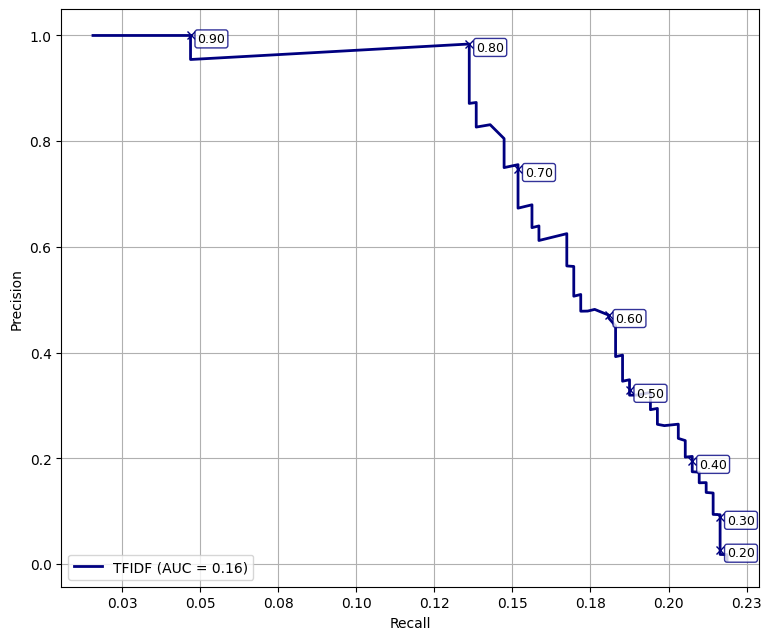

In [94]:
plt.figure(figsize=(9, 7.5))

plot_pr_curve(precision_points_all, recall_points_all, points, pr_auc_all, color='navy', label='TFIDF', threshold_points=threshold_points)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")
plt.grid(True)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels([f'{x:.2f}'.format(x) for x in current_values])
plt.savefig('./plots/PR_curve_all_mappings.png', dpi=150)

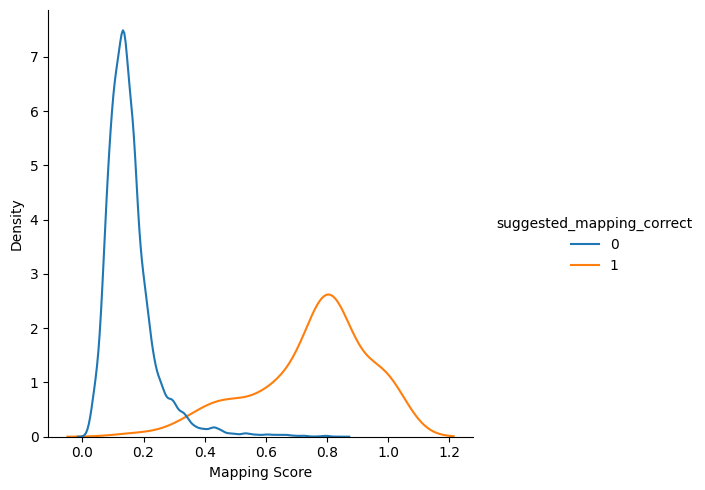

In [95]:
sns.displot(all_annotations, x="Mapping Score", kind='kde', hue='suggested_mapping_correct', common_norm=False)
plt.savefig('./plots/mapping_scores_density_all_mappings.png', dpi=150)

In [96]:
pd.set_option('display.max_rows', 100)

In [97]:
singles_annotated.loc[singles_annotated['suggested_mapping_correct']==1].sort_values(by='Mapping Score', ascending=False).head(100)

,assay_id,Source Term,Mapped Term Label,Mapped Term CURIE,Mapped Term IRI,Mapping Score,Tags,bao_id_mapped,suggested_mapping_correct
2711,1805757,Kinomescan assay,KINOMEScan assay,BAO:0003011,http://www.bioassayontology.org/bao#BAO_0003011,0.992,None,BAO_0003011,1
2811,1681112,Kinomescan assay,KINOMEScan assay,BAO:0003011,http://www.bioassayontology.org/bao#BAO_0003011,0.992,None,BAO_0003011,1
2512,1646002,KINOMEscan assay,KINOMEScan assay,BAO:0003011,http://www.bioassayontology.org/bao#BAO_0003011,0.992,None,BAO_0003011,1
2562,1679271,KINOMEscan assay,KINOMEScan assay,BAO:0003011,http://www.bioassayontology.org/bao#BAO_0003011,0.992,None,BAO_0003011,1
2612,1775920,KINOMEscan assay,KINOMEScan assay,BAO:0003011,http://www.bioassayontology.org/bao#BAO_0003011,0.992,None,BAO_0003011,1
2312,1578808,KINOMEScan assay,KINOMEScan assay,BAO:0003011,http://www.bioassayontology.org/bao#BAO_0003011,0.992,None,BAO_0003011,1
2412,1578804,KINOMEScan assay,KINOMEScan assay,BAO:0003011,http://www.bioassayontology.org/bao#BAO_0003011,0.992,None,BAO_0003011,1
43233,1329392,luciferase reporter gene assay,luciferase reporter gene assay,BAO:0002661,http://www.bioassayontology.org/bao#BAO_0002661,0.990,None,BAO_0002661,1
42993,877387,luciferase reporter gene assay,luciferase reporter gene assay,BAO:0002661,http://www.bioassayontology.org/bao#BAO_0002661,0.990,None,BAO_0002661,1
43473,1991216,luciferase reporter gene assay,luciferase reporter gene assay,BAO:0002661,http://www.bioassayontology.org/bao#BAO_0002661,0.990,None,BAO_0002661,1


In [98]:
singles_annotated.loc[singles_annotated['assay_id']==1773879].sort_values(by='Mapping Score', ascending=False).to_csv('./examples_for_manuscript/AI_1773879.csv', index=False)

In [99]:
multiples_ann_assay_ids.loc[multiples_ann_assay_ids['suggested_mapping_correct']==1].sort_values(by='Mapping Score', ascending=False).head(100)

,assay_id,Source Term,Mapped Term Label,Mapped Term CURIE,Mapped Term IRI,Mapping Score,Tags,bao_id_mapped,suggested_mapping_correct
2533,1708761,mass spectrometry based pull down assay,mass spectrometry,BAO:0000055,http://www.bioassayontology.org/bao#BAO_0000055,0.664,None,BAO_0000055,1
2733,1708497,mass spectrometry based pull down assay,mass spectrometry,BAO:0000055,http://www.bioassayontology.org/bao#BAO_0000055,0.664,None,BAO_0000055,1
2433,1708876,mass spectrometry based pull down assay,mass spectrometry,BAO:0000055,http://www.bioassayontology.org/bao#BAO_0000055,0.664,None,BAO_0000055,1
2633,1708895,mass spectrometry based pull down assay,mass spectrometry,BAO:0000055,http://www.bioassayontology.org/bao#BAO_0000055,0.664,None,BAO_0000055,1
2919,1727619,propidium iodide staining flow cytometry,flow cytometry,BAO:0000005,http://www.bioassayontology.org/bao#BAO_0000005,0.609,None,BAO_0000005,1
924,2105132,PI staining based flow cytometry analysis,flow cytometry,BAO:0000005,http://www.bioassayontology.org/bao#BAO_0000005,0.602,None,BAO_0000005,1
3179,966269,propidium iodide staining-based flow cytometry,flow cytometry,BAO:0000005,http://www.bioassayontology.org/bao#BAO_0000005,0.583,None,BAO_0000005,1
1022,2088061,annexin V-FITC and PI staining based flow cyto...,flow cytometry,BAO:0000005,http://www.bioassayontology.org/bao#BAO_0000005,0.542,None,BAO_0000005,1
0,1717246,Annexin V-FITC/propidium iodide based flow cyt...,flow cytometry,BAO:0000005,http://www.bioassayontology.org/bao#BAO_0000005,0.512,None,BAO_0000005,1
138,2067582,Annexin V-FITC/propidium iodide staining based...,flow cytometry,BAO:0000005,http://www.bioassayontology.org/bao#BAO_0000005,0.486,None,BAO_0000005,1


In [100]:
multiples_ann_assay_ids.loc[multiples_ann_assay_ids['assay_id']==1708761].sort_values(by='Mapping Score', ascending=False).to_csv('./examples_for_manuscript/AI_1708761.csv', index=False)

In [101]:
all_annotations.to_csv('./data/t2t_all_annotations_GS.csv', index=False)

### WRONG -- below is what happens when using the scikitlearn functionality
Precision is overestimated

In [69]:
y_true = merged_df['suggested_mapping_correct']
y_scores = merged_df['Mapping Score']
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
pr_auc = auc(recall, precision)

In [129]:
#######
threshold_points = np.arange(0.1, 1.0, 0.1)

# Plot all ROC curves

plt.figure(figsize=(9, 7.5))

#Function to plot multiple precision-recall curves on one graph
def plot_pr_curve(precision, recall, thresholds, pr_auc, label, color):
    plt.plot(recall, precision, color=color, lw=2, label=f'{label} (AUC = {pr_auc:.2f})')

    for threshold in threshold_points:
        # Find the closest point in the thresholds array
        idx = np.argmin(np.abs(thresholds - threshold))
        plt.annotate(f'{threshold:.2f}', (recall[idx], precision[idx]), textcoords="offset points", xytext=(-10,5), ha='center', color=color)
        plt.plot(recall[idx], precision[idx], 'x', markersize=5, color=color)

<Figure size 900x750 with 0 Axes>

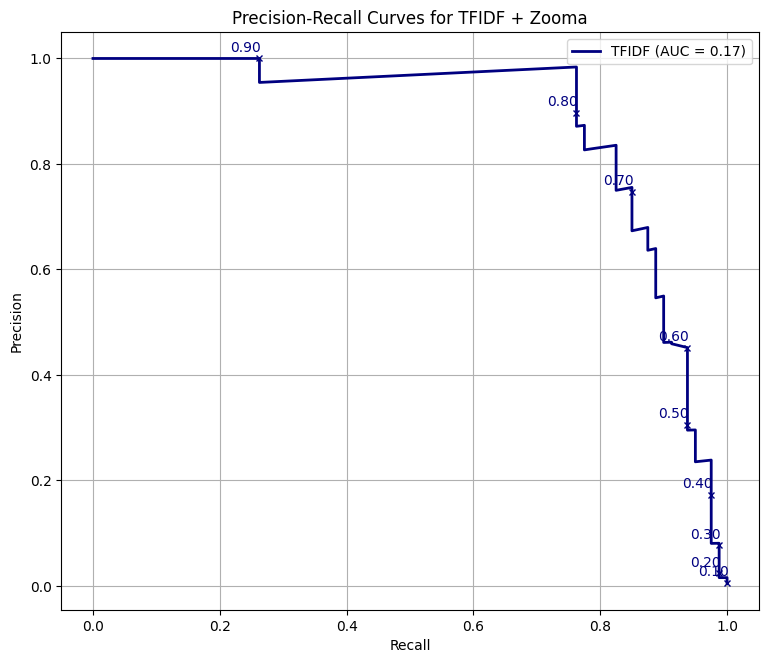

In [137]:
 
#######
plt.figure(figsize=(9, 7.5))

plot_pr_curve(precision, recall, thresholds, pr_auc, label='TFIDF', color='navy')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for TFIDF + Zooma')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()